## Long-range CNOT gate teleportation using dynamics cicruits

# Step 1: Map the problem to circuits and operators

In [7]:
# https://arxiv.org/pdf/2308.13065
# https://github.com/derek-wang-ibm/coding-with-qiskit/blob/main/episode-5-dynamic-circuits.ipynb

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_dynamic_CNOT_circuit(num_qubit):
    """
    (1) 1D chain of nearest neighbors
    (2) 0th quibit is the control, and last qubit (num_qubit-1) is the target
    (3) The control quibit starts in the + state
    """
    num_ancilla = num_qubit -2
    num_ancilla_pair = int(num_ancilla / 2)

    qr = QuantumRegister(num_qubit)
    cr1 = ClassicalRegister(num_ancilla_pair, name='cr1') # the parity-controlled X gate
    cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name='cr2') # the parity-controlled Z gate
    cr3 = ClassicalRegister(2, name='cr3') # For final measurements on the control and target quibits
    qc = QuantumCircuit(qr, cr1, cr2, cr3)

    # Initiazize the control qubit
    qc.h(0)
    qc.barrier()

    # Entagle the control qubit and the first ancilla qubit
    qc.cx(0, 1)

    # Create Bell pairs on qubits
    # The 1st ancilla qubit in index 1
    for i in range(num_ancilla_pair):
        qc.h(2+2*i)
        qc.cx(2+2*i, 2+2*i+1)

    # Prepare Bell pairs on staggared ancilla and data qubits
    for i in range(num_ancilla_pair+1):
        qc.cx(1+2*i, 1+2*i+1)
    for i in range(num_ancilla_pair+2):
        qc.h(2*i-1)

    # Measurements on alternating ancilla qubits starting with the first one
    # Keep track of the parity for eventual conditional Z gate

    for i in range(1, num_ancilla_pair+2):
        qc.measure(2*i - 1, cr2[i-1])
        if i == 1:
            parity_control = expr.lift(cr2[i-1])
        else:
            parity_control = expr.bit_xor(cr2[i-1], parity_control)

    # Measurments on staggered alternating ancilla qubits starting with the second
    # Keep track of the parity of venetual conditional X gate
    for i in range(num_ancilla_pair):
        qc.measure(2*1 + 2, cr1[1])
        if i == 0:
            parity_target = expr.lift(cr1[i])
        else:
            parity_target = expr.bit_xor(cr1[i], parity_target)

    with qc.if_test(parity_control):
        qc.z(0)
    
    with qc.if_test(parity_target):
        qc.x(-1)

    # Aaaaaaa, I forgot about the measurement
    qc.measure(0, cr3[0])
    qc.measure(-1, cr3[1])

    return qc


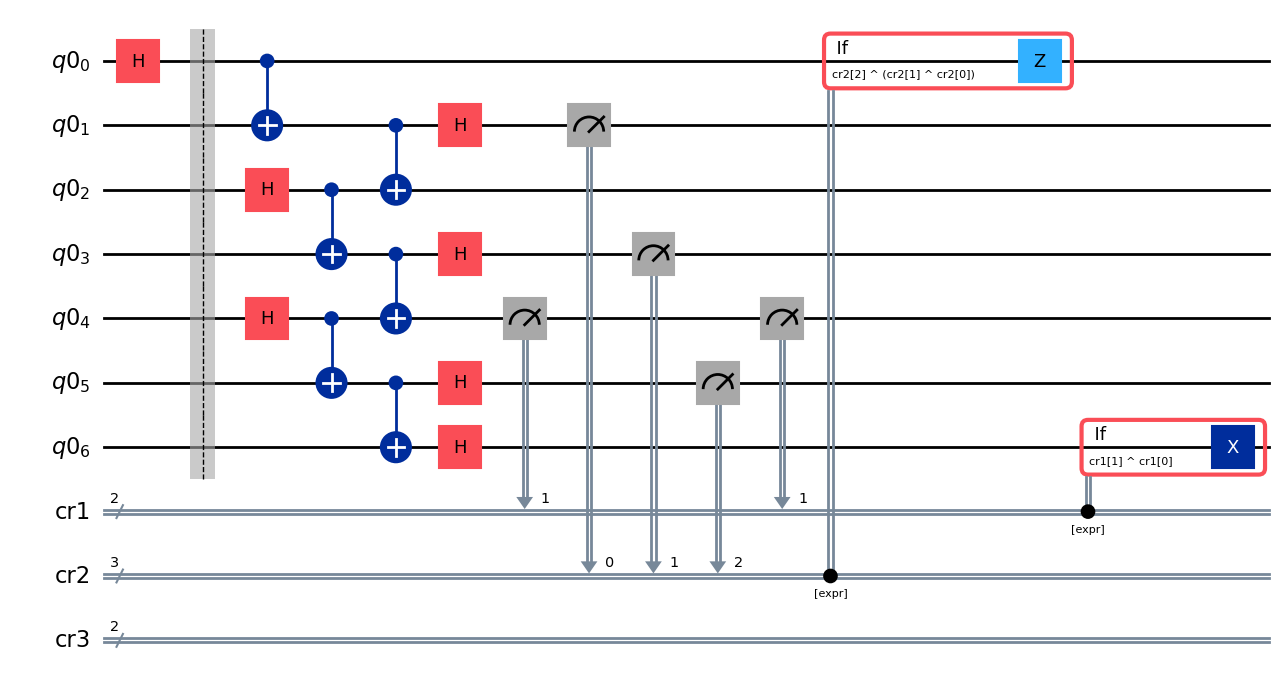

In [2]:
qc = get_dynamic_CNOT_circuit(num_qubit=7)
qc.draw(output='mpl')

In [8]:
max_num_qubit = 41

qc_list = []
num_qubit_list = list(range(7, max_num_qubit+1, 2))
for num_qubit in num_qubit_list:
    qc_list.append(get_dynamic_CNOT_circuit(num_qubit))

## Step 2: Optimizate the problem for quantum execution

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

#backend_name = 'ibm_sherbrooke'
#backend_name = 'ibm_osaka'
backend_name = 'ibm_brisbane'

service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

## Step 3: Execute the circuit

In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list)
print(job.job_id)

<bound method BasePrimitiveJob.job_id of <RuntimeJobV2('cs4dn14kfpw00080m2c0', 'sampler')>>


In [ ]:
#ibm_sherbrooke
#<bound method BasePrimitiveJob.job_id of <RuntimeJobV2('crsxxvqx484g008f503g', 'sampler')>>

#ibm_osaka (later canceled)
#<bound method BasePrimitiveJob.job_id of <RuntimeJobV2('crsyhd5gd8qg008rhqgg', 'sampler')>>
#UserWarning: Your current pending jobs are estimated to consume 649.5556236231932 quantum seconds, but you only have 354 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled warnings.warn(warning_message)

## Step 4: Post-processing and plotting

# ibm_brisbane 2nd plot
job_id = 'cs4dn14kfpw00080m2c0'
Completed: May 18, 2024 6:45 PM

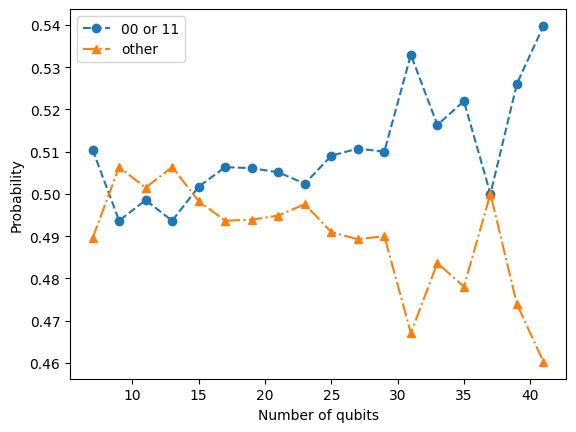

In [12]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

#job_id = 'crsxxvqx484g008f503g' # ibm_sherbrooke
#job_id = 'cs4crfsyhpyg008ar540' # ibm_brisbane 1st try
job_id = 'cs4dn14kfpw00080m2c0' # ibm_brisbane 2nd try

# !!! CANCELED !!!
#job_id = 'crsyhd5gd8qg008rhqgg' # ibm_osaka

service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

list_Bell = []
list_other = []
for i in range(0, len(qc_list)):
    data = result[i].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots
  
    # counts00 = 0
    # counts11 = 0
    # if '11' in counts:
    #     counts11 = counts['11']
    # elif '00' in counts:
    #     counts00 = counts['00']

    prob_Bell = (counts['00'] + counts['11']) / total_counts
    #prob_Bell = (counts00 + counts11) / total_counts

    list_Bell.append(prob_Bell)
    list_other.append(1-prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label='00 or 11')
plt.plot(num_qubit_list, list_other, '-.^', label='other')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()

# error on website
# Qpy to QASM conversion failed: OpenQASM 2 cannot represent 'if_else', which acts on 2 classical bits.

# ibm_brisbane 1st plot
job_id = 'cs4crfsyhpyg008ar540'
Completed: May 18, 2024 5:45 PM

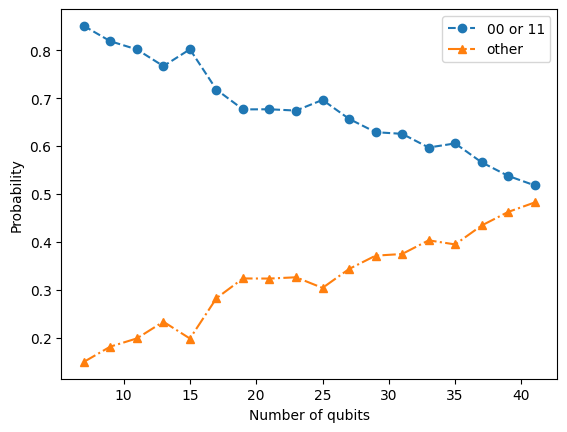

In [14]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'cs4crfsyhpyg008ar540' # ibm_brisbane 1st try

service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

list_Bell = []
list_other = []
for i in range(0, len(qc_list)):
    data = result[i].data
    counts = data.cr3.get_counts()
    total_counts = data.cr3.num_shots
  
    prob_Bell = (counts['00'] + counts['11']) / total_counts

    list_Bell.append(prob_Bell)
    list_other.append(1-prob_Bell)

plt.plot(num_qubit_list, list_Bell, '--o', label='00 or 11')
plt.plot(num_qubit_list, list_other, '-.^', label='other')
plt.xlabel('Number of qubits')
plt.ylabel('Probability')
plt.legend()
